<a href="https://colab.research.google.com/github/arunkumar-ra/ml-projects/blob/main/Finetuning_BERT_for_SQUAD_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### In this colab, we will attempt to fine tune BERT on SQUAD v1.1 dataset as described in the BERT paper.

#### When given a question and a context which contains the answer, the finetuned model can be used to select the portion of context which contains the answer.

#### Eg from Google search.
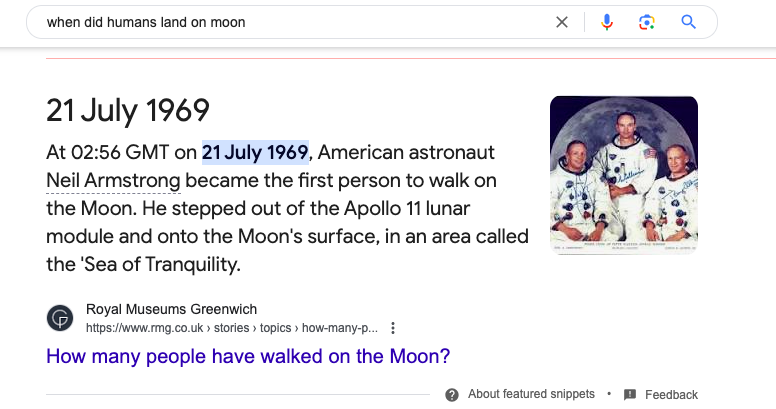

In [1]:
# For debugging. Get full cuda stack trace
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [4]:
import torch

In [6]:
# BERT MODELS
BERT_LARGE_UNCASED = "bert-large-uncased" # Ignores casing.
BERT_LARGE_CASED = "bert-large-cased" # Does not ignore casing.
BERT_BASE_UNCASED = "bert-base-uncased"
BERT_BASE_CASED = "bert-base-cased"

In [7]:
# Download the model for testing
from transformers import BertTokenizer, BertModel
# Using ALL_CAPS to avoid accidental overwrites by function scoped variable definitions.
TOKENIZER = BertTokenizer.from_pretrained(BERT_BASE_UNCASED)
MODEL = BertModel.from_pretrained(BERT_BASE_UNCASED)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [5]:
# Testing padding, etc.

def Test1():
  text = ["Replace me by any text you'd like.", "hi"]
  encoded_input = TOKENIZER(text, return_tensors='pt', padding=True)
  output = MODEL(**encoded_input)

  print(encoded_input)
Test1()

{'input_ids': tensor([[ 101, 5672, 2033, 2011, 2151, 3793, 2017, 1005, 1040, 2066, 1012,  102],
        [ 101, 7632,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}


In [ ]:
# Examine the model architecture
MODEL

In [2]:
%%capture
!pip install datasets

In [3]:
# Download SQUAD V1.1 dataset
from datasets import load_dataset
SQUAD = load_dataset("rajpurkar/squad")

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [8]:
# Note, the BERT tokenizer automatically adds a special token CLS = 101 and SEP = 102 at the beginning and the end of inputs respectively.
TOKENIZER.encode("")

[101, 102]

In [9]:
SQUAD['train'][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

In [10]:
# Sample processing for one example
# Process training set into tokens and labels
# question + context will be tokenized as the input. We add the question first and then the context to keep the structure similar to how BERT was pretrained.
# question is wrapped with special tokens CLS at the beginning and SEP at the end (similar to pretraining)
def SampleTest():
  sample_data = SQUAD['train'][0]

  sample_tokenized_input = TOKENIZER.encode(sample_data['question']) + TOKENIZER.encode(sample_data['context'], add_special_tokens=False)
  print("Input tokens: ", *sample_tokenized_input)

  # We will extract the token where the answer starts and the token where the answer ends and these will be our output labels
  # To find the first answer token number, use the answer_start entry and tokenize the input from that point.
  # Here we make an assumption that the answer always starts at a token boundary (eg. after a space)
  # Then work backwards to find the position of the first answer token.
  answer_start = sample_data['answers']['answer_start'][0]
  sample_tokenized_answer_start = TOKENIZER.encode(sample_data['context'][answer_start:], add_special_tokens=False)
  print("Truncated input tokens beginning with answer: ", *sample_tokenized_answer_start)

  answer_start_idx = len(sample_tokenized_input) - len(sample_tokenized_answer_start)
  answer_end_idx = len(TOKENIZER.encode(sample_data['answers']['text'][0], add_special_tokens=False)) + answer_start_idx

  # Sanity check
  print("Answer: ", TOKENIZER.decode(sample_tokenized_input[answer_start_idx:answer_end_idx]))
SampleTest()

Input tokens:  101 2000 3183 2106 1996 6261 2984 9382 3711 1999 8517 1999 10223 26371 2605 1029 102 6549 2135 1010 1996 2082 2038 1037 3234 2839 1012 10234 1996 2364 2311 1005 1055 2751 8514 2003 1037 3585 6231 1997 1996 6261 2984 1012 3202 1999 2392 1997 1996 2364 2311 1998 5307 2009 1010 2003 1037 6967 6231 1997 4828 2007 2608 2039 14995 6924 2007 1996 5722 1000 2310 3490 2618 4748 2033 18168 5267 1000 1012 2279 2000 1996 2364 2311 2003 1996 13546 1997 1996 6730 2540 1012 3202 2369 1996 13546 2003 1996 24665 23052 1010 1037 14042 2173 1997 7083 1998 9185 1012 2009 2003 1037 15059 1997 1996 24665 23052 2012 10223 26371 1010 2605 2073 1996 6261 2984 22353 2135 2596 2000 3002 16595 9648 4674 2061 12083 9711 2271 1999 8517 1012 2012 1996 2203 1997 1996 2364 3298 1006 1998 1999 1037 3622 2240 2008 8539 2083 1017 11342 1998 1996 2751 8514 1007 1010 2003 1037 3722 1010 2715 2962 6231 1997 2984 1012
Truncated input tokens beginning with answer:  3002 16595 9648 4674 2061 12083 9711 2271 1999

In [10]:
# Special tokens
CLS = "[CLS]"
SEP = "[SEP]"

In [11]:
MAX_TOKENS = 512
BATCH_SIZE = 16
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
# Convert batch_size examples into input format
def convert_to_input_format(rows):
  inputs = [(CLS + rows['question'][idx] + SEP + rows['context'][idx]) for idx in range(len(rows['id']))]
  tokenized_input = TOKENIZER(inputs, padding='longest', add_special_tokens=False, truncation=True)

  y = torch.zeros((BATCH_SIZE, 2), dtype=torch.long)
  for idx in range(0, len(rows['id'])):
    answer_start = rows['answers'][idx]['answer_start'][0]
    # Get all tokens before the anwer starts
    tokenized_answer_start = TOKENIZER.encode(CLS + rows['question'][idx] + SEP + rows['context'][idx][:answer_start], add_special_tokens=False)
    answer_start_idx = len(tokenized_answer_start)

    # Verify that the indexes are sane. Out of bounds labels cause the training to break downstream.
    assert answer_start_idx > 0
    answer_end_idx = len(TOKENIZER.encode(rows['answers'][idx]['text'][0], add_special_tokens=False)) + answer_start_idx - 1
    if answer_start_idx >= len(tokenized_input['input_ids'][idx]):
      answer_start_idx = 0
      answer_end_idx = 0
    assert answer_end_idx < len(tokenized_input['input_ids'][idx])
    y[idx][0] = answer_start_idx
    y[idx][1] = answer_end_idx

  return tokenized_input, y

## Load training data set. If already pre-processed load directly from gdrive, otherwise, skip to next cell to process and write the training data to gdrive.

In [61]:
# Load processed data set directly from gdrive if available.
from google.colab import drive
drive.mount('/content/gdrive')

X_TOK = torch.load(F"/content/gdrive/MyDrive/squad_v1p1_batch" + str(BATCH_SIZE) + "_input")
Y_TOK = torch.load(F"/content/gdrive/MyDrive/squad_v1p1_batch" + str(BATCH_SIZE) + "_label")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Process the entire training set. Takes around 10 minutes to process.
X_TOK, Y_TOK = [], []
print("Total rows: ", len(SQUAD['train']))
for idx in range(0, len(SQUAD['train']) - BATCH_SIZE, BATCH_SIZE):
  rows = SQUAD['train'][idx:idx+BATCH_SIZE]
  x_i, y_i = convert_to_input_format(rows)

  X_TOK.append(x_i)
  Y_TOK.append(y_i)

  if idx % (50*BATCH_SIZE) == 0:
    print("Processed: ", idx)

In [31]:
# Save the processed dataset to a gdrive so we don't have to process it again.
from google.colab import drive
drive.mount('/content/gdrive')

def save_object(my_object, file_name):
  path = F"/content/gdrive/MyDrive/{file_name}"
  torch.save(my_object, path)

save_object(X_TOK, "squad_v1p1_batch" + str(BATCH_SIZE) + "_input")
save_object(Y_TOK, "squad_v1p1_batch" + str(BATCH_SIZE) + "_label")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [62]:
# Split the train set into training and devel.
# We will use the original devel set as test.
from sklearn.model_selection import train_test_split
X_TRAIN, X_DEV, Y_TRAIN, Y_DEV = train_test_split(X_TOK, Y_TOK, test_size=0.1, random_state=42)

In [13]:
import numpy as np

def get_random_batch(x, y):
  idx = np.random.randint(len(x))
  return x[idx], y[idx]

In [35]:
import torch.nn as nn
from torch.nn import functional as F

# hidden_size = 768

class BertSquadModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained(BERT_BASE_UNCASED)
        self.S = nn.Linear(self.bert.config.hidden_size, 1, bias=False) # TODO: Try later with bias = True?
        self.E = nn.Linear(self.bert.config.hidden_size, 1, bias=False)

    def forward(self, input_ids, attention_mask, prediction):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = bert_output.last_hidden_state # (B, T, hidden_size)
        S_logits = self.S(last_hidden_state).squeeze(-1) # B, T
        E_logits = self.E(last_hidden_state).squeeze(-1) # B, T
        loss = F.cross_entropy(S_logits, prediction[0]) + F.cross_entropy(E_logits, prediction[1])

        return loss

    def get_best_start_end_positions(self, input_ids, attention_mask):
      # Is setting this necessary?
      self.eval()
      bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
      last_hidden_state = bert_output.last_hidden_state # (B, T, hidden_size)
      S_logits = self.S(last_hidden_state).squeeze(-1) # B, T
      E_logits = self.E(last_hidden_state).squeeze(-1) # B, T

      # Softmax along T dimension.
      S_softmax = F.softmax(S_logits, dim=-1)
      E_softmax = F.softmax(E_logits, dim=-1)

      B, T = S_logits.shape
      # For each S = Ti, find Tj such that i < j and j = argmax(Tj)
      se_positions = torch.zeros((B, 2), dtype=torch.long)
      for batch in range(0, B):
        max_prob = 0.0
        max_end_loc = T-1
        for token in range(0, T-1):
          start = T - token - 2
          if S_softmax[batch][start] * E_softmax[batch][max_end_loc] > max_prob:
            se_positions[batch][0] = start
            se_positions[batch][1] = max_end_loc
            max_prob = S_softmax[batch][start] * E_softmax[batch][max_end_loc]
          if E_softmax[batch][start] > E_softmax[batch][max_end_loc]:
            max_end_loc = start

      self.train()
      return se_positions


In [36]:
MODEL = BertSquadModel()
MODEL = MODEL.to(DEVICE)

# print the number of parameters in the model
print(sum(p.numel() for p in MODEL.parameters())/1e6, 'M parameters')

109.483776 M parameters


In [67]:
LEARNING_RATE = 5e-5
# SQUAD finetuning should run for a total of 3 epochs according to BERT paper.
EPOCHS = 1
OPTIMIZER = torch.optim.AdamW(MODEL.parameters(), lr=LEARNING_RATE)


In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

def save_model(model, file_name):
  path = F"/content/gdrive/MyDrive/{file_name}"
  torch.save(model.state_dict(), path)

def update_model_from(file_name):
  path = F"/content/gdrive/My Drive/{file_name}"
  MODEL.load_state_dict(torch.load(path))

Mounted at /content/gdrive


In [64]:
loss_tracker = {'train': [], 'val': [], 'iter': []}

In [63]:
@torch.no_grad()
def estimate_loss():
    MODEL.eval()
    eval_iters = 5
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
        xb, yb = get_random_batch(X_DEV, Y_DEV)
        xb_input_ids = torch.tensor(xb['input_ids'], dtype=torch.long)
        xb_attention_mask = torch.tensor(xb['attention_mask'], dtype=torch.long)
        xb_input_ids = xb_input_ids.to(DEVICE)
        xb_attention_mask = xb_attention_mask.to(DEVICE)
        yb = yb.to(DEVICE)

        eval_loss = MODEL(xb_input_ids, xb_attention_mask, yb.T)
        losses[k] = eval_loss.item()
    MODEL.train()
    return losses.mean()


In [23]:
import torch
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

## To continue training from a previous checkpoint load the model from gdrive.

In [65]:
# To continue training from checkpoint, fetch model checkpoint from drive.
update_model_from('bert_finetune_v2')

## Start the training. You can use `watch nvidia-smi` to monitor GPU usage.

In [ ]:
# For profiling.
# with profile(activities=[ProfilerActivity.CUDA], record_shapes=True, profile_memory=True, with_flops=True, use_cuda=True) as prof:
#   with record_function("model_training"):
def RunTraining():
  for epoch in range(EPOCHS):
    mini_loss = []
    for idx in range(0, len(X_TRAIN)):
      xb, yb = X_TRAIN[idx], Y_TRAIN[idx]
      xb_input_ids = torch.tensor(xb['input_ids'], dtype=torch.long)
      xb_attention_mask = torch.tensor(xb['attention_mask'], dtype=torch.long)
      xb_input_ids = xb_input_ids.to(DEVICE)
      xb_attention_mask = xb_attention_mask.to(DEVICE)
      yb = yb.to(DEVICE)

      # Forward pass
      loss = MODEL(xb_input_ids, xb_attention_mask, yb.T)
      mini_loss.append(loss.item())
      if idx % 40 == 0:
        loss_tracker['train'].append(np.mean(mini_loss))
        mini_loss = []

        # Evaluate loss on dev.
        loss_tracker['val'].append(estimate_loss())
        loss_tracker['iter'].append(epoch * len(X_TRAIN) + idx)
        print(loss_tracker['iter'][-1], loss_tracker['train'][-1], loss_tracker['val'][-1])

      OPTIMIZER.zero_grad(set_to_none=True)
      loss.backward()
      OPTIMIZER.step()
    print("Epoch complete. Saving checkpoint.")
    save_model(MODEL, 'bert_finetune_v2')

# Note: Last training checkpoint is after 2 epochs. We can potentially finetune the model for one more epoch.
RunTraining()

0 0.21715658903121948 tensor(2.2385)
40 1.5505393393337727 tensor(2.2665)
80 1.4429506115615367 tensor(2.1346)
120 1.4053089708089828 tensor(2.4567)
160 1.3952091850340367 tensor(1.4160)
200 1.346600041538477 tensor(1.9254)
240 1.4474309168756008 tensor(1.5053)
280 1.3029310453683138 tensor(1.8261)
320 1.2974381171166898 tensor(1.9646)
360 1.2609787054359913 tensor(2.5829)
400 1.3293742258101702 tensor(2.2221)
440 1.0650062564760447 tensor(1.8627)
480 1.1338659714907409 tensor(2.0339)
520 1.3282895788550377 tensor(1.6037)
560 1.2224042028188706 tensor(2.8437)
600 1.1978044830262662 tensor(1.7161)
640 1.3625453539192676 tensor(1.7375)
680 1.27839809730649 tensor(2.4513)
720 0.9642533160746097 tensor(2.3991)
760 1.4044527411460876 tensor(1.6835)
800 1.1454872086644172 tensor(1.4326)
840 1.0518669717013835 tensor(3.1374)
880 1.284445045888424 tensor(1.8126)
920 1.4686404723674058 tensor(1.5637)


In [28]:
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                  volta_sgemm_128x64_nt         0.00%       0.000us         0.00%       0.000us       0.000us        6.398s        24.16%        6.398s       3.703ms           0 b           0 b           0 b           0 

## Loss curve of first training run.

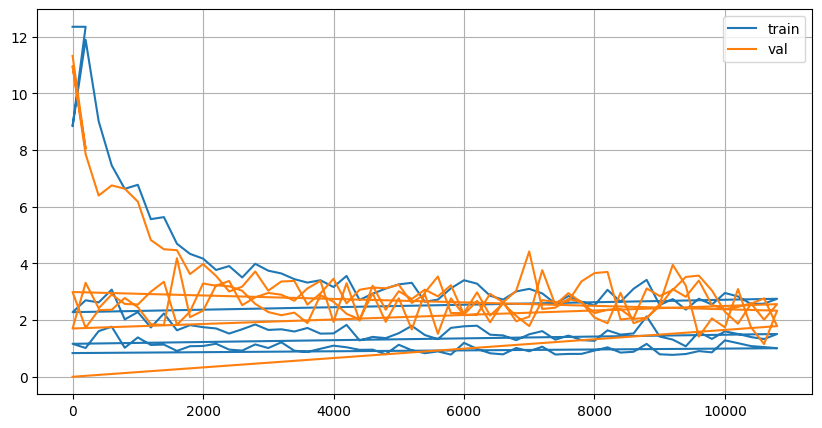

In [61]:
# prompt: plot loss_tracker['train'] and loss_tracker['val'] on the same curve

import matplotlib.pyplot as plt

plt.plot(loss_tracker['iter'], loss_tracker['train'], label='train')
plt.plot(loss_tracker['iter'], loss_tracker['val'], label='val')
# Increase size of plot
plt.rcParams["figure.figsize"] = (20,5)

plt.legend()
plt.grid()
plt.show()

# Show grid


## Loss curve of second training run.

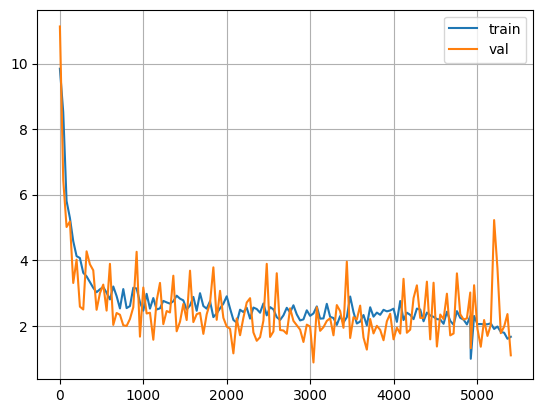

In [28]:
# Second training run - epoch 1
# Updates:
# -- added attention mask to input
# -- changed batch size from 32 to 16 to prevent GPU OOMs

import matplotlib.pyplot as plt

plt.plot(loss_tracker['iter'], loss_tracker['train'], label='train')
plt.plot(loss_tracker['iter'], loss_tracker['val'], label='val')
# Increase size of plot
plt.rcParams["figure.figsize"] = (20,5)

plt.legend()
plt.grid()
plt.show()

# Show grid

## Evaluate test accuracy

In [20]:
SQUAD['validation'][1]

{'id': '56be4db0acb8001400a502ed',
 'title': 'Super_Bowl_50',
 'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.',
 'question': 'Which NFL team represented the NFC at Super Bowl 50?',
 'answers': {'text': ['Carolina Panthers',
   'Carolina Panthers',
   'Caroli

In [28]:
TEST_INPUT, TEST_OUTPUT = convert_to_input_format(SQUAD['validation'][0:BATCH_SIZE])

In [38]:
def RunTest():
  xb_input_ids = torch.tensor(TEST_INPUT['input_ids'], dtype=torch.long)
  xb_attention_mask = torch.tensor(TEST_INPUT['attention_mask'], dtype=torch.long)
  xb_input_ids = xb_input_ids.to(DEVICE)
  xb_attention_mask = xb_attention_mask.to(DEVICE)

  # Forward pass
  return MODEL.get_best_start_end_positions(xb_input_ids, xb_attention_mask)

MODEL = MODEL.to(DEVICE)
PREDICTION = RunTest()

In [60]:
for idx in range(16):
  print(SQUAD['validation'][idx]) # context and question
  start = PREDICTION[idx][0]
  end = PREDICTION[idx][1]
  print("Predicted answer: ", TOKENIZER.decode(TEST_INPUT['input_ids'][idx][start:end+1]))
  print("Expected answer: ", TOKENIZER.decode(TEST_INPUT['input_ids'][idx][TEST_OUTPUT[idx][0]:TEST_OUTPUT[idx][1]+1]))

{'id': '56be4db0acb8001400a502ec', 'title': 'Super_Bowl_50', 'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.', 'question': 'Which NFL team represented the AFC at Super Bowl 50?', 'answers': {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'ans

#### We ran the above test after 2 epochs of fine tuning. On manual evaluation, we got 11 correct answers, 2 partially correct and 3 wrong answers. TODO: Evaluate accuracy of the full test set. Multiple correct answers per question means that some additional work is needed to correctly evaluate the test accuracy.